In [ ]:
!python -m spacy download fr_core_news_sm

2023-12-10 16:23:26.157577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 16:23:27.311564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 71.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy
import random
import matplotlib.pyplot as plt
from torch.nn import functional as F
import math
from tqdm import tqdm
import seaborn as sns
from collections import Counter


# EDA Analysis

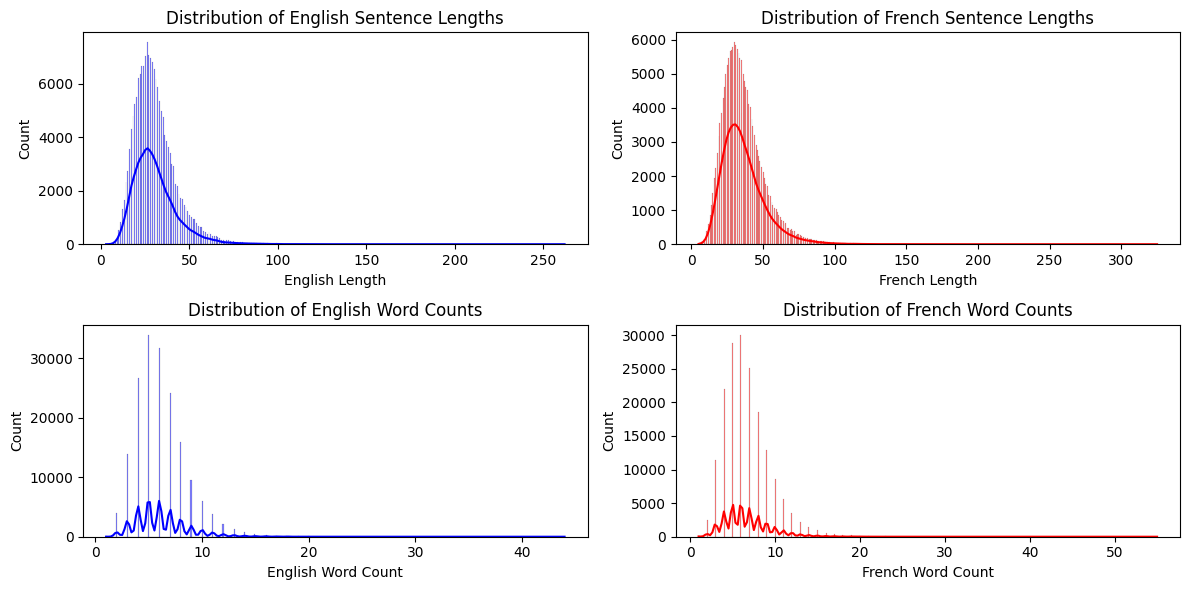

In [ ]:
data = pd.read_csv("eng_-french.csv")
data['English Length'] = data['English words/sentences'].apply(len)
data['French Length'] = data['French words/sentences'].apply(len)

data['English Word Count'] = data['English words/sentences'].apply(lambda x: len(x.split()))
data['French Word Count'] = data['French words/sentences'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(data['English Length'], kde=True, color='blue')
plt.title('Distribution of English Sentence Lengths')

plt.subplot(2, 2, 2)
sns.histplot(data['French Length'], kde=True, color='red')
plt.title('Distribution of French Sentence Lengths')

plt.subplot(2, 2, 3)
sns.histplot(data['English Word Count'], kde=True, color='blue')
plt.title('Distribution of English Word Counts')

plt.subplot(2, 2, 4)
sns.histplot(data['French Word Count'], kde=True, color='red')
plt.title('Distribution of French Word Counts')

plt.tight_layout()
plt.show()


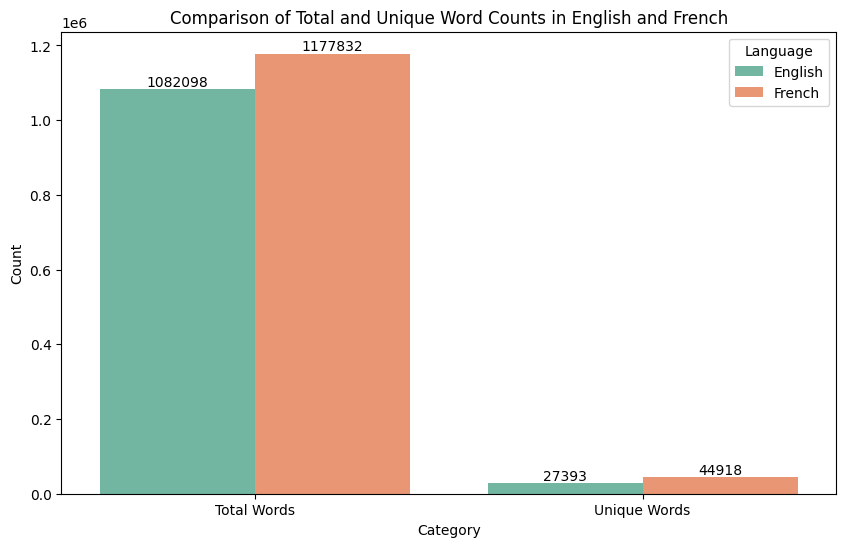

In [ ]:
english_total, english_unique = count_words(data['English words/sentences'])
french_total, french_unique = count_words(data['French words/sentences'])

word_counts_df = pd.DataFrame({
    'Category': ['Total Words', 'Unique Words'],
    'English': [english_total, english_unique],
    'French': [french_total, french_unique]
})

word_counts_melted = word_counts_df.melt(id_vars='Category', var_name='Language', value_name='Count')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Category', y='Count', hue='Language', data=word_counts_melted, palette='Set2')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Comparison of Total and Unique Word Counts in English and French')
plt.show()


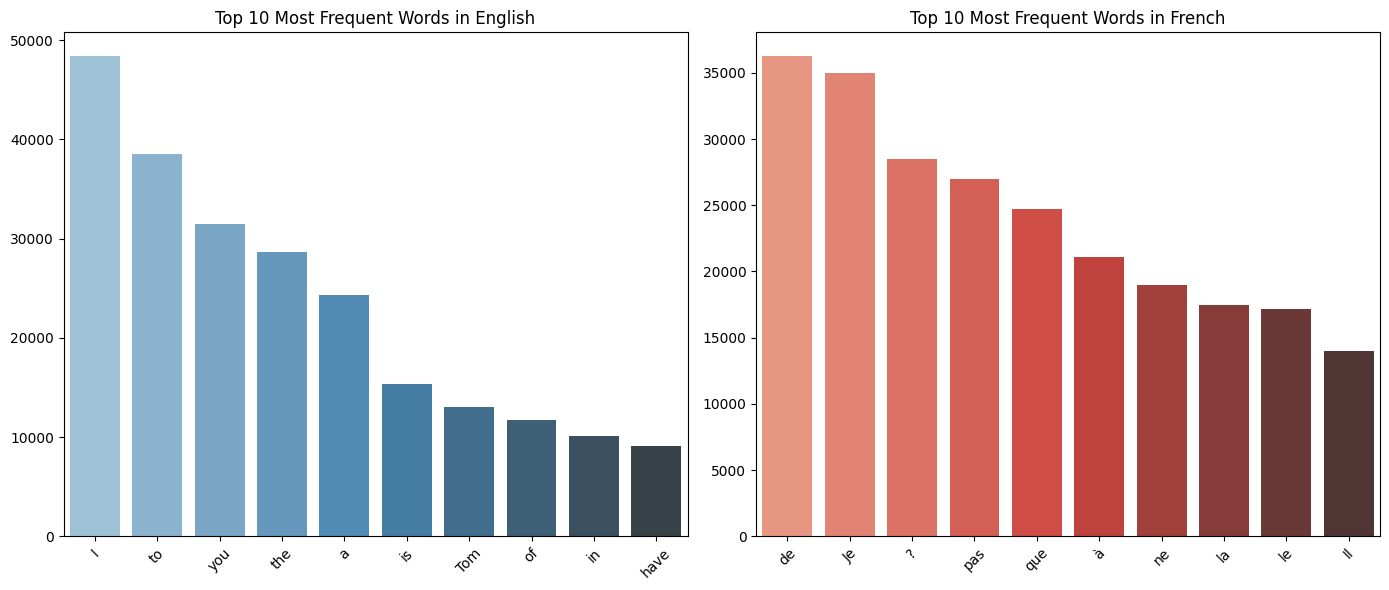

In [ ]:
english_word_counts = Counter(' '.join(data['English words/sentences']).split())
french_word_counts = Counter(' '.join(data['French words/sentences']).split())

english_common_words = english_word_counts.most_common(10)
french_common_words = french_word_counts.most_common(10)

english_words, english_counts = zip(*english_common_words)
french_words, french_counts = zip(*french_common_words)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=list(english_words), y=list(english_counts), palette="Blues_d")
plt.title('Top 10 Most Frequent Words in English')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=list(french_words), y=list(french_counts), palette="Reds_d")
plt.title('Top 10 Most Frequent Words in French')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



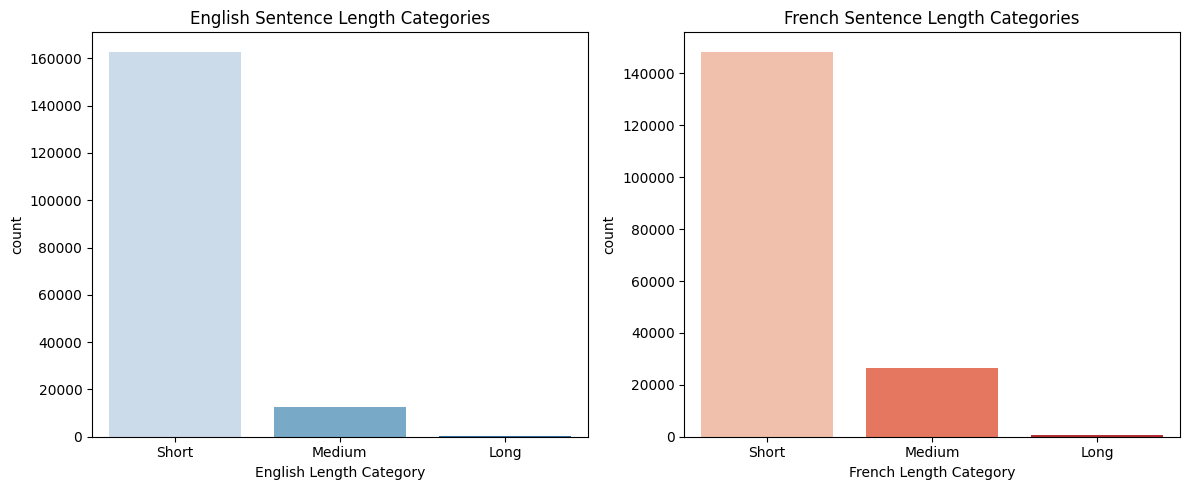

In [ ]:

def categorize_length(length):
    if length < 50:
        return 'Short'
    elif length < 100:
        return 'Medium'
    else:
        return 'Long'

def get_start_end_words(sentences):
    start_words = [sentence.split()[0] for sentence in sentences if sentence]
    end_words = [sentence.split()[-1] for sentence in sentences if sentence]
    return Counter(start_words), Counter(end_words)

data['English Length Category'] = data['English Length'].apply(categorize_length)
data['French Length Category'] = data['French Length'].apply(categorize_length)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=data['English Length Category'], order=['Short', 'Medium', 'Long'], palette="Blues")
plt.title('English Sentence Length Categories')

plt.subplot(1, 2, 2)
sns.countplot(x=data['French Length Category'], order=['Short', 'Medium', 'Long'], palette="Reds")
plt.title('French Sentence Length Categories')

plt.tight_layout()
plt.show()



In [ ]:

spacy_eng = spacy.load('en_core_web_sm')
spacy_fr = spacy.load('fr_core_news_sm')

def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]

def tokenize_fr(text):
    return [tok.text for tok in spacy_fr.tokenizer(text)]

class CustomTextDataset(Dataset):
    def __init__(self, filename, src_tokenizer, trg_tokenizer):
        self.data = pd.read_csv(filename)
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.data.iloc[idx, 0]
        trg = self.data.iloc[idx, 1]
        return src, trg


file_path = 'eng_-french.csv'
SRC = get_tokenizer(tokenize_eng)
TRG = get_tokenizer(tokenize_fr)
dataset = CustomTextDataset(file_path, SRC, TRG)


def yield_tokens(data_iter, tokenizer):
    for _, data in enumerate(data_iter):
        yield tokenizer(data[0])

SRC_VOCAB = build_vocab_from_iterator(yield_tokens(dataset, SRC), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
TRG_VOCAB = build_vocab_from_iterator(yield_tokens(dataset, TRG), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
SRC_VOCAB.set_default_index(SRC_VOCAB['<unk>'])
TRG_VOCAB.set_default_index(TRG_VOCAB['<unk>'])


text_transform = {
    'src': lambda x: [SRC_VOCAB['<bos>']] + [SRC_VOCAB[token] for token in SRC(x)] + [SRC_VOCAB['<eos>']],
    'trg': lambda x: [TRG_VOCAB['<bos>']] + [TRG_VOCAB[token] for token in TRG(x)] + [TRG_VOCAB['<eos>']]
}


def collate_batch(batch):
    src_list, trg_list = [], []
    for src_sample, trg_sample in batch:
        src_list.append(torch.tensor(text_transform['src'](src_sample), dtype=torch.int64))
        trg_list.append(torch.tensor(text_transform['trg'](trg_sample), dtype=torch.int64))
    src = pad_sequence(src_list, padding_value=SRC_VOCAB['<pad>'])
    trg = pad_sequence(trg_list, padding_value=TRG_VOCAB['<pad>'])
    return src, trg

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)

src_vocab_size = len(SRC_VOCAB)
trg_vocab_size = len(TRG_VOCAB)


In [ ]:

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden


class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs).unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs).permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), torch.zeros_like(hidden.unsqueeze(0))))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs


In [ ]:

def calculate_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)
    non_pad_elements = (y != TRG_VOCAB['<pad>']).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements]).sum()
    return correct.item() / len(y[non_pad_elements])

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for _, batch in enumerate(iterator):
        src, trg = batch
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        acc = calculate_accuracy(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            src, trg = batch
            output = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            acc = calculate_accuracy(output, trg)
            epoch_loss += loss.item()
            epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:

INPUT_DIM = src_vocab_size
OUTPUT_DIM = trg_vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.01

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model11 = Seq2Seq(enc, dec, device).to(device)


criterion11 = nn.CrossEntropyLoss(ignore_index=TRG_VOCAB['<pad>'])
optimizer11 = optim.Adam(model11.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)




In [1]:
NUM_EPOCHS = 30
CLIP = 1

train_losses11 = []
test_losses11 = []
train_accuracies11 = []
test_accuracies11 =[]

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model11, train_loader, optimizer11, criterion11, CLIP)
    test_loss, test_acc = evaluate(model11, test_loader, criterion11)
    train_losses11.append(train_loss)
    test_losses11.append(test_loss)
    train_accuracies11.append(train_acc)
    test_accuracies11.append(test_acc)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {test_loss:.3f}, Val. Acc: {test_acc*100:.2f}%')



Epoch: 1, Train Loss: 1.012, Train Acc: 76.08%, Val. Loss: 0.864, Val. Acc: 75.27%
Epoch: 2, Train Loss: 0.723, Train Acc: 79.68%, Val. Loss: 0.845, Val. Acc: 74.75%
Epoch: 3, Train Loss: 0.678, Train Acc: 80.25%, Val. Loss: 0.763, Val. Acc: 75.87%
Epoch: 4, Train Loss: 0.653, Train Acc: 80.64%, Val. Loss: 0.762, Val. Acc: 75.75%
Epoch: 5, Train Loss: 0.635, Train Acc: 80.93%, Val. Loss: 0.773, Val. Acc: 75.27%
Epoch: 6, Train Loss: 0.623, Train Acc: 81.10%, Val. Loss: 0.746, Val. Acc: 76.58%
Epoch: 7, Train Loss: 0.614, Train Acc: 81.29%, Val. Loss: 0.730, Val. Acc: 76.50%
Epoch: 8, Train Loss: 0.608, Train Acc: 81.37%, Val. Loss: 0.717, Val. Acc: 77.17%
Epoch: 9, Train Loss: 0.600, Train Acc: 81.50%, Val. Loss: 0.719, Val. Acc: 76.67%
Epoch: 10, Train Loss: 0.596, Train Acc: 81.60%, Val. Loss: 0.737, Val. Acc: 76.43%
Epoch: 11, Train Loss: 0.596, Train Acc: 81.58%, Val. Loss: 0.736, Val. Acc: 76.76%
Epoch: 12, Train Loss: 0.590, Train Acc: 81.69%, Val. Loss: 0.724, Val. Acc: 76.07%
E

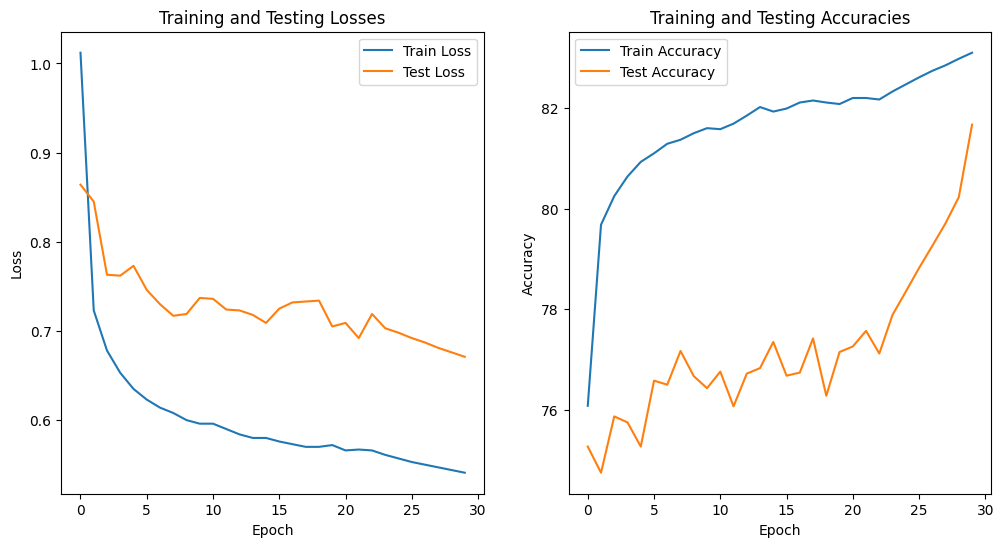

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses11, label='Train Loss')
plt.plot(test_losses11, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies11, label='Train Accuracy')
plt.plot(test_accuracies11, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.show()


In [30]:
import torch

model11.eval()

test_loss11, test_acc11 = evaluate(model11, test_loader, criterion11)
print(f'Test Loss: {test_loss11:.3f}, Test Acc: {test_acc11*100:.2f}%')



Test Loss: 0.671, Test Acc: 81.67%


Bleu score

In [ ]:
from torchtext.data.metrics import bleu_score


In [ ]:
def calculate_bleu(data_loader, model, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device):
    targets = []
    outputs = []

    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            src, trg = batch
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0)

            output = output.argmax(2).cpu().numpy()
            trg = trg.cpu().numpy()

            for i in range(output.shape[1]):
                trg_sent = [TRG_VOCAB.lookup_token(token) for token in trg[:, i] if token != TRG_VOCAB['<pad>']]
                output_sent = [TRG_VOCAB.lookup_token(token) for token in output[1:, i] if token != TRG_VOCAB['<pad>']]
                targets.append([trg_sent])
                outputs.append(output_sent)

    return bleu_score(outputs, targets)


In [7]:
bleu_score = calculate_bleu(test_loader, model11, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device)
print(f'BLEU Score: {bleu_score*100:.2f}')


BLEU Score:  35.6


LSTM Model 2

In [ ]:

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        a = self.attention(hidden, encoder_outputs).unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs).permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), torch.zeros_like(hidden.unsqueeze(0))))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        prediction = F.log_softmax(prediction, dim=1)

        return prediction, hidden.squeeze(0)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs


In [ ]:

def calculate_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)
    non_pad_elements = (y != TRG_VOCAB['<pad>']).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements]).sum()
    return correct.item() / len(y[non_pad_elements])

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for _, batch in enumerate(iterator):
        src, trg = batch
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        acc = calculate_accuracy(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            src, trg = batch
            output = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            acc = calculate_accuracy(output, trg)
            epoch_loss += loss.item()
            epoch_acc += acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [ ]:
from torch.optim import AdamW
INPUT_DIM = src_vocab_size
OUTPUT_DIM = trg_vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.001

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model12 = Seq2Seq(enc, dec, device).to(device)


criterion12 = nn.NLLLoss(ignore_index=TRG_VOCAB['<pad>'])
optimizer12 = optim.AdamW(model12.parameters(), lr=LEARNING_RATE)





In [ ]:
NUM_EPOCHS = 30
CLIP = 1

train_losses12 = []
test_losses12 = []
train_accuracies12 = []
test_accuracies12 = []
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model12, train_loader, optimizer12, criterion12, CLIP)
    test_loss, test_acc = evaluate(model12, test_loader, criterion12)
    train_losses12.append(train_loss)
    test_losses12.append(test_loss)

    train_accuracies12.append(train_acc)
    test_accuracies12.append(test_acc)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {test_loss:.3f}, Val. Acc: {test_acc*100:.2f}%')





Epoch: 01, Train Loss: 1.145, Train Acc: 74.68%, Val. Loss: 0.943, Val. Acc: 74.45%
Epoch: 02, Train Loss: 0.794, Train Acc: 78.88%, Val. Loss: 0.827, Val. Acc: 75.69%
Epoch: 03, Train Loss: 0.704, Train Acc: 80.01%, Val. Loss: 0.770, Val. Acc: 76.37%
Epoch: 04, Train Loss: 0.638, Train Acc: 81.10%, Val. Loss: 0.760, Val. Acc: 76.56%
Epoch: 05, Train Loss: 0.593, Train Acc: 81.65%, Val. Loss: 0.749, Val. Acc: 76.59%
Epoch: 06, Train Loss: 0.561, Train Acc: 82.02%, Val. Loss: 0.773, Val. Acc: 76.20%
Epoch: 07, Train Loss: 0.530, Train Acc: 82.51%, Val. Loss: 0.728, Val. Acc: 77.05%
Epoch: 08, Train Loss: 0.507, Train Acc: 82.91%, Val. Loss: 0.730, Val. Acc: 77.00%
Epoch: 09, Train Loss: 0.486, Train Acc: 83.31%, Val. Loss: 0.734, Val. Acc: 77.26%
Epoch: 10, Train Loss: 0.462, Train Acc: 83.96%, Val. Loss: 0.728, Val. Acc: 77.27%
Epoch: 11, Train Loss: 0.445, Train Acc: 84.41%, Val. Loss: 0.739, Val. Acc: 77.38%
Epoch: 12, Train Loss: 0.432, Train Acc: 84.74%, Val. Loss: 0.738, Val. Acc:

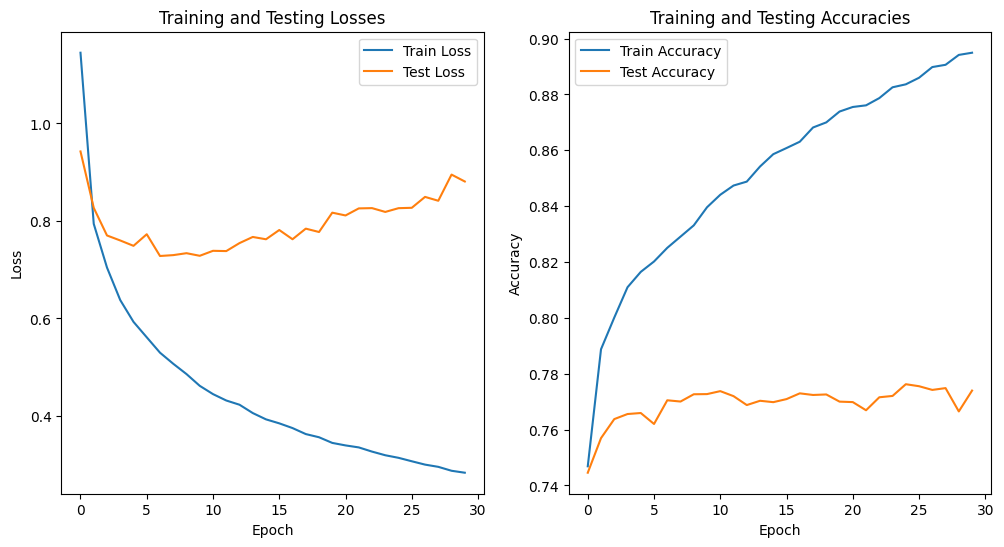

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses12, label='Train Loss')
plt.plot(test_losses12, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies12, label='Train Accuracy')
plt.plot(test_accuracies12, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.show()


In [8]:
import torch


model12.eval()

test_loss12, test_acc12 = evaluate(model12, test_loader, criterion12)
print(f'Test Loss: {test_loss12:.3f}, Test Acc: {test_acc12*100:.2f}%')


Test Loss: 0.882, Test Acc: 77.40%


In [ ]:
from torchtext.data.metrics import bleu_score


In [ ]:
def calculate_bleu(data_loader, model, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device):
    targets = []
    outputs = []

    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            src, trg = batch
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0)

            output = output.argmax(2).cpu().numpy()
            trg = trg.cpu().numpy()

            for i in range(output.shape[1]):
                trg_sent = [TRG_VOCAB.lookup_token(token) for token in trg[:, i] if token != TRG_VOCAB['<pad>']]
                output_sent = [TRG_VOCAB.lookup_token(token) for token in output[1:, i] if token != TRG_VOCAB['<pad>']]
                targets.append([trg_sent])
                outputs.append(output_sent)

    return bleu_score(outputs, targets)


In [9]:
bleu_score = calculate_bleu(test_loader, model12, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device)
print(f'BLEU Score: {bleu_score*100:.2f}')


BLEU Score: 31.34


LSTM Model 3

In [ ]:
INPUT_DIM = src_vocab_size
OUTPUT_DIM = trg_vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.01

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model13 = Seq2Seq(enc, dec, device).to(device)

criterion13 = nn.CrossEntropyLoss(ignore_index=TRG_VOCAB['<pad>'])
optimizer13 = optim.RMSprop(model13.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)





In [15]:
NUM_EPOCHS = 30
CLIP = 1

train_losses13 = []
test_losses13 = []
train_accuracies13 = []
test_accuracies13 = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model13, train_loader, optimizer13, criterion13, CLIP)
    test_loss, test_acc = evaluate(model13, test_loader, criterion13)

    train_losses13.append(train_loss)
    test_losses13.append(test_loss)

    train_accuracies13.append(train_acc)
    test_accuracies13.append(test_acc)

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {test_loss:.3f}, Val. Acc: {test_acc*100:.2f}%')


Epoch: 01, Train Loss: 2.896, Train Acc: 66.73%, Val. Loss: 0.994, Val. Acc: 73.39%
Epoch: 02, Train Loss: 0.837, Train Acc: 77.25%, Val. Loss: 1.776, Val. Acc: 69.15%
Epoch: 03, Train Loss: 0.748, Train Acc: 78.54%, Val. Loss: 0.794, Val. Acc: 75.87%
Epoch: 04, Train Loss: 0.686, Train Acc: 79.48%, Val. Loss: 1.160, Val. Acc: 70.64%
Epoch: 05, Train Loss: 0.664, Train Acc: 80.10%, Val. Loss: 0.862, Val. Acc: 72.09%
Epoch: 06, Train Loss: 0.631, Train Acc: 80.55%, Val. Loss: 0.769, Val. Acc: 75.69%
Epoch: 07, Train Loss: 0.614, Train Acc: 80.86%, Val. Loss: 0.758, Val. Acc: 75.58%
Epoch: 08, Train Loss: 0.740, Train Acc: 79.75%, Val. Loss: 0.739, Val. Acc: 76.19%
Epoch: 09, Train Loss: 0.611, Train Acc: 80.87%, Val. Loss: 0.736, Val. Acc: 76.39%
Epoch: 10, Train Loss: 0.590, Train Acc: 81.23%, Val. Loss: 0.717, Val. Acc: 76.89%
Epoch: 11, Train Loss: 0.579, Train Acc: 81.55%, Val. Loss: 0.733, Val. Acc: 76.06%
Epoch: 12, Train Loss: 0.775, Train Acc: 79.61%, Val. Loss: 0.709, Val. Acc:

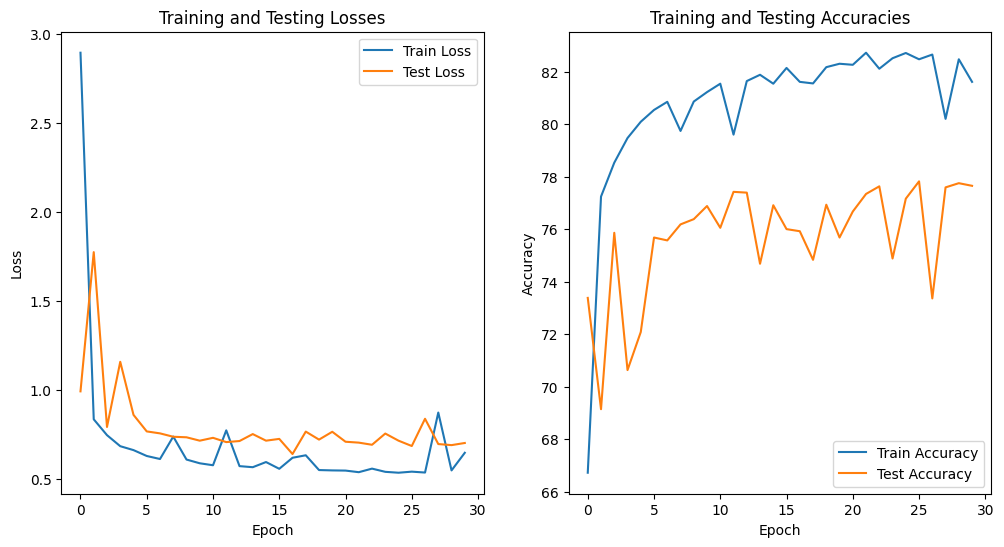

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses13, label='Train Loss')
plt.plot(test_losses13, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracies13, label='Train Accuracy')
plt.plot(test_accuracies13, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.show()


In [10]:
import torch

model13.eval()

test_loss13, test_acc13 = evaluate(model13, test_loader, criterion13)
print(f'Test Loss: {test_loss13:.3f}, Test Acc: {test_acc13*100:.2f}%')


Test Loss: 0.704, Test Acc: 77.68%


In [ ]:
from nltk.translate.bleu_score import corpus_bleu


In [ ]:
from torchtext.data.metrics import bleu_score


In [ ]:
def calculate_bleu(data_loader, model, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device):
    targets = []
    outputs = []

    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            src, trg = batch
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0)

            output = output.argmax(2).cpu().numpy()
            trg = trg.cpu().numpy()

            for i in range(output.shape[1]):
                trg_sent = [TRG_VOCAB.lookup_token(token) for token in trg[:, i] if token != TRG_VOCAB['<pad>']]
                output_sent = [TRG_VOCAB.lookup_token(token) for token in output[1:, i] if token != TRG_VOCAB['<pad>']]
                targets.append([trg_sent])
                outputs.append(output_sent)

    return bleu_score(outputs, targets)


In [ ]:
bleu_score = calculate_bleu(test_loader, model13, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device)
print(f'BLEU Score: {bleu_score*100:.2f}')


BLEU Score: 30.03


GRU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class EncoderGRU(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return hidden

class DecoderGRU(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        context = context.unsqueeze(0)

        emb_con = torch.cat((embedded, context), dim=2)

        output, hidden = self.rnn(emb_con, hidden.unsqueeze(0))

        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        context = context.squeeze(0)

        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))

        return prediction, hidden.squeeze(0)

class Seq2SeqGRU(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0,:]

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs




In [18]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for _, batch in enumerate(iterator):
        src, trg = batch
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def calculate_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)
    non_pad_elements = (y != TRG_VOCAB['<pad>']).nonzero(as_tuple=True)
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements]).sum()
    return correct.item() / len(y[non_pad_elements])

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for _, batch in enumerate(iterator):
            src, trg = batch
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, 0)

            output_dim = output.shape[-1]

            output = output[1:].reshape(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)
            acc = calculate_accuracy(output, trg)

            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(iterator), epoch_acc / len(iterator)




In [20]:
INPUT_DIM = len(SRC_VOCAB)
OUTPUT_DIM = len(TRG_VOCAB)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
import random

enc = EncoderGRU(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, ENC_DROPOUT)
dec = DecoderGRU(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, DEC_DROPOUT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model31 = Seq2SeqGRU(enc, dec, device).to(device)

optimizer31 = optim.Adam(model31.parameters())
criterion31 = nn.CrossEntropyLoss(ignore_index=TRG_VOCAB['<pad>'])

NUM_EPOCHS = 30
CLIP = 1
train_losses31 = []
test_losses31 = []
test_accuracies31 = []
train_accuracies31 = []

for epoch in range(NUM_EPOCHS):
    train_loss = train(model31, train_loader, optimizer31, criterion31, CLIP)
    train_loss, train_acc = evaluate(model31, train_loader, criterion31)
    test_loss, test_acc = evaluate(model31, test_loader, criterion31)

    train_losses31.append(train_loss)
    test_losses31.append(test_loss)
    test_accuracies31.append(test_acc)
    train_accuracies31.append(train_acc)

    print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')



Epoch: 1 | Train Loss: 0.949 | Train Acc: 74.55% | Test Loss: 0.958 | Test Acc: 74.52%
Epoch: 2 | Train Loss: 0.888 | Train Acc: 74.46% | Test Loss: 0.916 | Test Acc: 74.56%
Epoch: 3 | Train Loss: 0.796 | Train Acc: 76.75% | Test Loss: 0.851 | Test Acc: 76.06%
Epoch: 4 | Train Loss: 0.745 | Train Acc: 76.63% | Test Loss: 0.824 | Test Acc: 75.92%
Epoch: 5 | Train Loss: 0.736 | Train Acc: 77.38% | Test Loss: 0.840 | Test Acc: 75.78%
Epoch: 6 | Train Loss: 0.687 | Train Acc: 76.42% | Test Loss: 0.815 | Test Acc: 74.73%
Epoch: 7 | Train Loss: 0.651 | Train Acc: 77.93% | Test Loss: 0.814 | Test Acc: 75.43%
Epoch: 8 | Train Loss: 0.658 | Train Acc: 77.24% | Test Loss: 0.833 | Test Acc: 74.70%
Epoch: 9 | Train Loss: 0.609 | Train Acc: 78.58% | Test Loss: 0.804 | Test Acc: 75.73%
Epoch: 10 | Train Loss: 0.677 | Train Acc: 75.68% | Test Loss: 0.879 | Test Acc: 72.93%
Epoch: 11 | Train Loss: 0.593 | Train Acc: 78.50% | Test Loss: 0.821 | Test Acc: 74.75%
Epoch: 12 | Train Loss: 0.556 | Train Acc

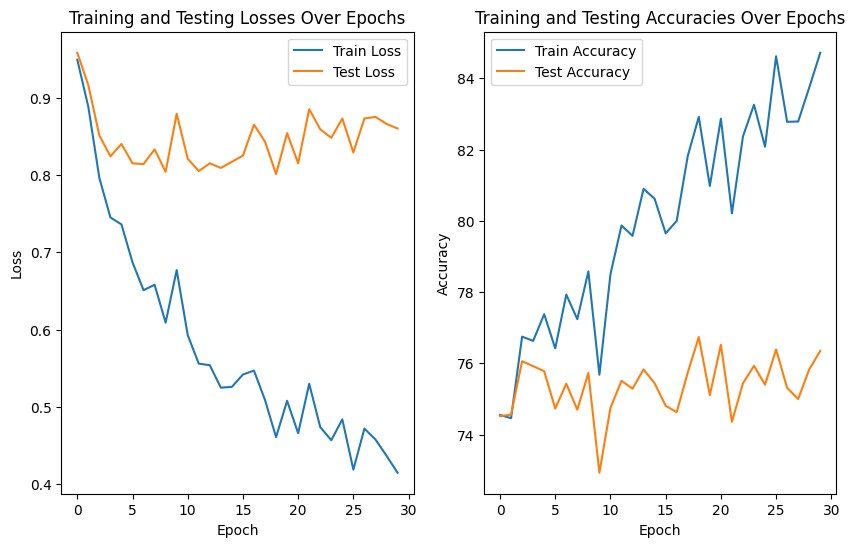

In [21]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses31, label='Train Loss')
plt.plot(test_losses31, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Losses Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies31, label='Train Accuracy')
plt.plot(test_accuracies31, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracies Over Epochs')

plt.show()


In [22]:
import torch

model31.eval()

test_loss11, test_acc11 = evaluate(model31, test_loader, criterion31)
print(f'Test Loss: {test_loss11:.3f}, Test Acc: {test_acc11*100:.2f}%')


Test Loss: 0.861, Test Acc: 76.29%


BLEU Score-GRU

In [ ]:
from torchtext.data.metrics import bleu_score


In [ ]:
def calculate_bleu(data_loader, model, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device):
    targets = []
    outputs = []

    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            src, trg = batch
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0)

            output = output.argmax(2).cpu().numpy()
            trg = trg.cpu().numpy()

            for i in range(output.shape[1]):
                trg_sent = [TRG_VOCAB.lookup_token(token) for token in trg[:, i] if token != TRG_VOCAB['<pad>']]
                output_sent = [TRG_VOCAB.lookup_token(token) for token in output[1:, i] if token != TRG_VOCAB['<pad>']]
                targets.append([trg_sent])
                outputs.append(output_sent)

    return bleu_score(outputs, targets)


In [ ]:
bleu_score = calculate_bleu(test_loader, model31, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device)
print(f'BLEU Score: {bleu_score*100:.2f}')


BLEU Score: 30.23


GRU model 2

In [23]:

INPUT_DIM = len(SRC_VOCAB)
OUTPUT_DIM = len(TRG_VOCAB)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
import random

enc = EncoderGRU(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, ENC_DROPOUT)
dec = DecoderGRU(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, DEC_DROPOUT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model32 = Seq2SeqGRU(enc, dec, device).to(device)

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = nn.functional.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

criterion32 = LabelSmoothingCrossEntropy()

optimizer32 = optim.SGD(model32.parameters(), lr=0.01, momentum=0.9)


NUM_EPOCHS = 30
CLIP = 1


train_losses32 = []
test_losses32 = []
test_accuracies32 = []
train_accuracies32 = []

for epoch in range(NUM_EPOCHS):
    train_loss = train(model32, train_loader, optimizer32, criterion32, CLIP)
    train_loss, train_acc = evaluate(model32, train_loader, criterion32)
    test_loss, test_acc = evaluate(model32, test_loader, criterion32)

    train_losses32.append(train_loss)
    test_losses32.append(test_loss)
    test_accuracies32.append(test_acc)
    train_accuracies32.append(train_acc)

    print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


Epoch: 1 | Train Loss: 0.893 | Train Acc: 60.45% | Test Loss: 0.940 | Test Acc: 71.47%
Epoch: 2 | Train Loss: 0.878 | Train Acc: 61.57% | Test Loss: 0.960 | Test Acc: 68.51%
Epoch: 3 | Train Loss: 0.824 | Train Acc: 62.16% | Test Loss: 0.934 | Test Acc: 68.87%
Epoch: 4 | Train Loss: 0.815 | Train Acc: 62.94% | Test Loss: 0.934 | Test Acc: 68.48%
Epoch: 5 | Train Loss: 0.811 | Train Acc: 64.32% | Test Loss: 0.872 | Test Acc: 68.85%
Epoch: 6 | Train Loss: 0.798 | Train Acc: 64.50% | Test Loss: 0.919 | Test Acc: 68.57%
Epoch: 7 | Train Loss: 0.758 | Train Acc: 65.99% | Test Loss: 0.874 | Test Acc: 68.33%
Epoch: 8 | Train Loss: 0.724 | Train Acc: 66.12% | Test Loss: 0.875 | Test Acc: 69.83%
Epoch: 9 | Train Loss: 0.739 | Train Acc: 67.12% | Test Loss: 0.870 | Test Acc: 69.49%
Epoch: 10 | Train Loss: 0.680 | Train Acc: 67.75% | Test Loss: 0.857 | Test Acc: 67.43%
Epoch: 11 | Train Loss: 0.694 | Train Acc: 67.69% | Test Loss: 0.812 | Test Acc: 70.46%
Epoch: 12 | Train Loss: 0.655 | Train Acc

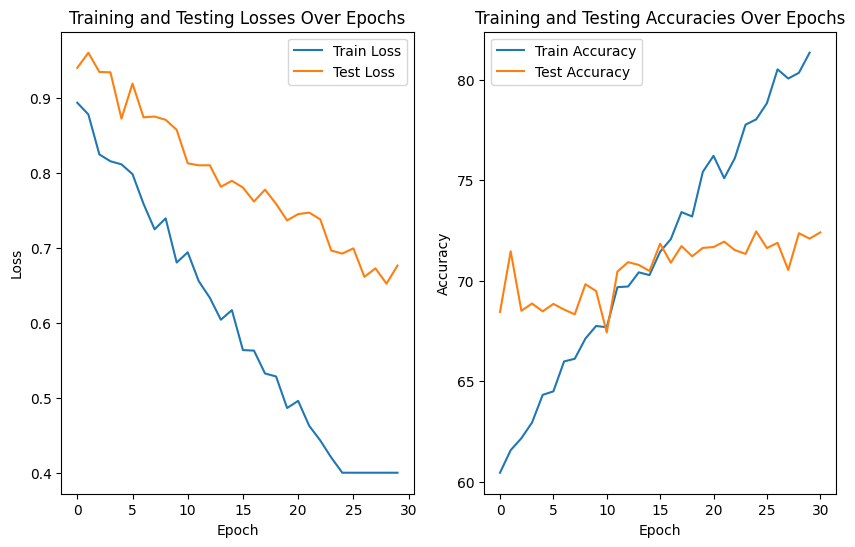

In [27]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses32, label='Train Loss')
plt.plot(test_losses32, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Losses Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies32, label='Train Accuracy')
plt.plot(test_accuracies32, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracies Over Epochs')

plt.show()

In [ ]:
import torch

model32.eval()

test_loss12, test_acc12 = evaluate(model32, test_loader, criterion32)
print(f'Test Loss: {test_loss12:.3f}, Test Acc: {test_acc12*100:.2f}%')



Test Loss: 2.028, Test Acc: 55.92%
Model GRU32 training complete and saved.


In [ ]:
from torchtext.data.metrics import bleu_score


In [ ]:
def calculate_bleu(data_loader, model, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device):
    targets = []
    outputs = []

    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            src, trg = batch
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0)

            output = output.argmax(2).cpu().numpy()
            trg = trg.cpu().numpy()

            for i in range(output.shape[1]):
                trg_sent = [TRG_VOCAB.lookup_token(token) for token in trg[:, i] if token != TRG_VOCAB['<pad>']]
                output_sent = [TRG_VOCAB.lookup_token(token) for token in output[1:, i] if token != TRG_VOCAB['<pad>']]
                targets.append([trg_sent])
                outputs.append(output_sent)

    return bleu_score(outputs, targets)


In [26]:
bleu_score = calculate_bleu(test_loader, model32, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device)
print(f'BLEU Score: {bleu_score*100:.2f}')

BLEU Score:  25.58


BERT

In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 1.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sacrebleu import corpus_bleu

file_path = 'eng_-french.csv'
data = pd.read_csv(file_path)


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    return tokenizer.encode(text, add_special_tokens=True, max_length=128, padding='max_length', truncation=True)

data['English_encoded'] = data['English words/sentences'].apply(preprocess_text)
data['French_encoded'] = data['French words/sentences'].apply(preprocess_text)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.25)  # 0.25 * 0.8 = 0.2


In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        return {
            'english': torch.tensor(item['English_encoded']),
            'french': torch.tensor(item['French_encoded'])
        }

train_dataset = TranslationDataset(train_data)
val_dataset = TranslationDataset(val_data)
test_dataset = TranslationDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)


In [ ]:
class TranslationModel(nn.Module):
    def __init__(self):
        super(TranslationModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.decoder = nn.Linear(self.bert.config.hidden_size, tokenizer.vocab_size)

    def forward(self, input_ids):
        with torch.no_grad():
            encoded = self.bert(input_ids)[0]
        return self.decoder(encoded)

model = TranslationModel()
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm import tqdm

def train(model, loader):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training", leave=False):
        optimizer.zero_grad()
        output = model(batch['english'])
        loss = criterion(output.transpose(1, 2), batch['french'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            output = model(batch['english'])
            loss = criterion(output.transpose(1, 2), batch['french'])
            total_loss += loss.item()
    return total_loss / len(loader)



train_losses, val_losses = [], []

epochs = 20
for epoch in range(epochs):
    train_loss = train(model, train_loader)
    val_loss = validate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")




In [ ]:
from tqdm import tqdm

def train(model, loader):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training", leave=False):
        optimizer.zero_grad()
        output = model(batch['english'])
        loss = criterion(output.transpose(1, 2), batch['french'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            output = model(batch['english'])
            loss = criterion(output.transpose(1, 2), batch['french'])
            total_loss += loss.item()
    return total_loss / len(loader)



train_losses, val_losses = [], []

epochs = 20
for epoch in range(epochs):
    train_loss = train(model, train_loader)
    val_loss = validate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")





Epoch 01 - Train Loss: 1.092, Val. Loss: 0.863
Epoch 02 - Train Loss: 0.723, Val. Loss: 0.799
Epoch 03 - Train Loss: 0.667, Val. Loss: 0.755
Epoch 04 - Train Loss: 0.639, Val. Loss: 0.744
Epoch 05 - Train Loss: 0.622, Val. Loss: 0.720
Epoch 06 - Train Loss: 0.616, Val. Loss: 0.715
Epoch 07 - Train Loss: 0.606, Val. Loss: 0.712
Epoch 08 - Train Loss: 0.599, Val. Loss: 0.705
Epoch 09 - Train Loss: 0.592, Val. Loss: 0.709
Epoch 10 - Train Loss: 0.585, Val. Loss: 0.714
Epoch 11 - Train Loss: 0.584, Val. Loss: 0.704
Epoch 12 - Train Loss: 0.577, Val. Loss: 0.728
Epoch 13 - Train Loss: 0.577, Val. Loss: 0.724
Epoch 14 - Train Loss: 0.571, Val. Loss: 0.728
Epoch 15 - Train Loss: 0.572, Val. Loss: 0.720
Epoch 16 - Train Loss: 0.575, Val. Loss: 0.700
Epoch 17 - Train Loss: 0.571, Val. Loss: 0.699
Epoch 18 - Train Loss: 0.570, Val. Loss: 0.720
Epoch 19 - Train Loss: 0.571, Val. Loss: 0.702
Epoch 20 - Train Loss: 0.570, Val. Loss: 0.699


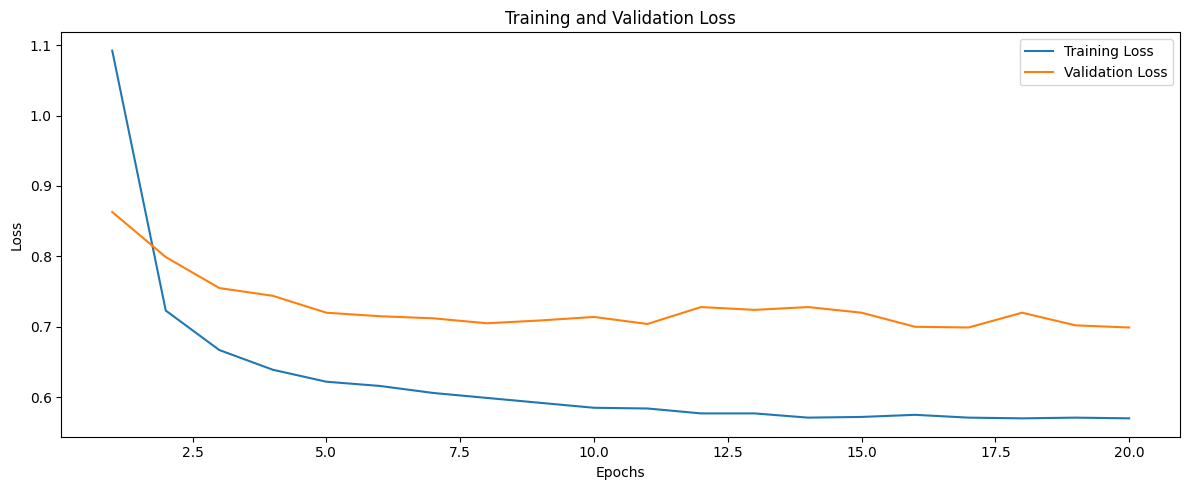

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 21)

plt.figure(figsize=(12, 5))


plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(data_loader, model, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device):
    targets = []
    outputs = []

    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(data_loader):
            src, trg = batch
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0)

            output = output.argmax(2).cpu().numpy()
            trg = trg.cpu().numpy()

            for i in range(output.shape[1]):
                trg_sent = [TRG_VOCAB.lookup_token(token) for token in trg[:, i] if token != TRG_VOCAB['<pad>']]
                output_sent = [TRG_VOCAB.lookup_token(token) for token in output[1:, i] if token != TRG_VOCAB['<pad>']]
                targets.append([trg_sent])
                outputs.append(output_sent)

    return bleu_score(outputs, targets)
bleu_score = calculate_bleu(test_loader, model, SRC_VOCAB, TRG_VOCAB, SRC, TRG, device)
print(f'BLEU Score: {bleu_score*100:.2f}')


BLEU Score: 31.97
